# 1. Info

Notebook with all the code needed to solve the homework for the week four of the machine learning zoomcamp.

## Install the required libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # SplitData
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold

## Getting the data

 
For this homework, we'll use the Car price dataset. Download it from here.

In [2]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv

We'll work with the __MSRP__ variable, and we'll transform it to a classification task.

For the rest of the homework, you'll need to use only these columns:

* Make,
* Model,
* Year,
* Engine HP,
* Engine Cylinders,
* Transmission Type,
* Vehicle Style,
* highway MPG,
* city mpg,
* MSRP

__Data preparation__

* Keep only the columns above
* Lowercase the column names and replace spaces with underscores
* Fill the missing values with 0
* Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average
* Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [3]:
data = pd.read_csv('./data.csv')

In [4]:
df = data[['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg','MSRP']].copy()

In [5]:
df.columns = df.columns.str.lower().str.replace(' ','_')

In [6]:
df.fillna(0, inplace=True)

In [7]:
df['above_average'] = (df['msrp'] > np.mean(df['msrp'])).astype(int)

In [8]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [9]:
y_train = df_train['above_average']
y_val = df_val['above_average']
y_test = df_test['above_average']

del df_train["msrp"] 
del df_val["msrp"]
del df_test["msrp"] 
del df_train["above_average"] 
del df_val["above_average"]
del df_test["above_average"] 

# Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the above_average variable
* Use the training dataset for that

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

* engine_hp
* engine_cylinders
* highway_mpg
* city_mpg

In [10]:
numerical_cols = ['year', 'engine_hp', 'engine_cylinders',  'highway_mpg', 'city_mpg']
for column in numerical_cols:
    roc_auc = round(roc_auc_score(y_train, df_train[column]),3)
    if roc_auc < 0.5:
        roc_auc = round(roc_auc_score(y_train, -df_train[column]),3)
    print(f"{column} = {roc_auc}")

year = 0.688
engine_hp = 0.917
engine_cylinders = 0.766
highway_mpg = 0.633
city_mpg = 0.673


# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
What's the AUC of this model on the validation dataset? (round to 3 digits)

* 0.678
* 0.779
* 0.878
* 0.979

In [11]:
dv = DictVectorizer(sparse=False)

# vectorize data
train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

# initialize and train the Logistic Regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict_proba(X_val)[:, 1]

In [12]:
# calculate roc
round(roc_auc_score(y_val, y_pred),3)

0.979

# Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.28
* 0.48
* 0.68
* 0.88

In [13]:
scores = []

thresholds = np.linspace(0.0, 1.0, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    # true 
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    # false
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [14]:
# adding precision and recall here because inside the for loop is giving me a warning
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

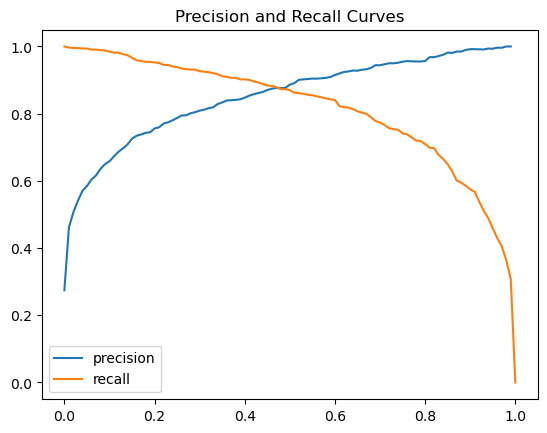

In [15]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.title('Precision and Recall Curves')
plt.legend();

In [16]:
df_scores['difference'] = abs(df_scores['precision']-df_scores['recall'])

In [17]:
df_scores.sort_values(by=['difference'], ascending=True).head(3)

,threshold,tp,fp,fn,tn,precision,recall,difference
48,0.48,571,81,83,1648,0.875767,0.873089,0.002678
47,0.47,575,81,79,1648,0.876524,0.879205,0.002681
49,0.49,571,80,83,1649,0.877112,0.873089,0.004023


# Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

        F1 = 2((P.R)/(P+R))

Where 
 is precision and 
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

* 0.12
* 0.32
* 0.52
* 0.72

In [18]:
df_scores['F1'] = 2*((df_scores['precision']*df_scores['recall'])/(df_scores['precision']+df_scores['recall']))

In [19]:
df_scores.sort_values(by=['F1'], ascending=False).head(3)

,threshold,tp,fp,fn,tn,precision,recall,difference,F1
52,0.52,563,62,91,1667,0.900800,0.860856,0.039944,0.880375
53,0.53,562,61,92,1668,0.902087,0.859327,0.042759,0.880188
54,0.54,560,60,94,1669,0.903226,0.856269,0.046957,0.879121


# Question 5: 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
* Use AUC to evaluate the model on validation

How large is standard devidation of the scores across different folds?

* 0.003
* 0.030
* 0.090
* 0.140

In [20]:
KFold= KFold(n_splits=5, shuffle=True, random_state=1)

In [21]:
df_train_full.reset_index(drop=True, inplace=True)

In [22]:
scores = []

for train_idx, val_idx in KFold.split(df_train_full):
        
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train['above_average']
        y_val = df_val['above_average']

        del df_train['above_average']
        del df_val['above_average']
        
        dv = DictVectorizer(sparse=False)

        # vectorize data
        train_dict = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)

        # initialize and train the Logistic Regression model
        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model.fit(X_train, y_train)

        # make predictions
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

In [23]:
print(f'standard deviation:{np.std(scores)}')

standard deviation:2.933929986049027e-06


In [24]:
round(np.std(scores),3)

0.0

# Question 6: Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: [0.01, 0.1, 0.5, 10]
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

* 0.01
* 0.1
* 0.5
* 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [27]:
for C_values in [0.01, 0.1, 0.5, 10]:
    
    scores_6 = []

    for train_idx, val_idx in KFold.split(df_train_full):
            
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train['above_average']
        y_val = df_val['above_average']

        del df_train['above_average']
        del df_val['above_average']
        
        dv = DictVectorizer(sparse=False)

        # vectorize data
        train_dict = df_train.to_dict(orient='records')
        X_train = dv.fit_transform(train_dict)

        val_dict = df_val.to_dict(orient='records')
        X_val = dv.transform(val_dict)

        # initialize and train the Logistic Regression model
        model = LogisticRegression(solver='liblinear', C=C_values, max_iter=1000)
        model.fit(X_train, y_train)

        # make predictions
        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores_6.append(auc)
        
    print(f'C{C_values}, standard deviation:{np.std(scores_6)}')

C0.01, standard deviation:2.933929986049027e-06
C0.1, standard deviation:2.9339299860053673e-06
C0.5, standard deviation:2.933929986049027e-06
C10, standard deviation:2.933929986049027e-06


# End of the notebook